<a href="https://colab.research.google.com/github/NoraHK3/DataSciProject/blob/main/Model_Attempt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === 1. Imports ===
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
from google.colab import files
uploaded = files.upload()

Saving all_images.zip to all_images.zip
Saving final_dataset_paths.csv to final_dataset_paths.csv


In [3]:
import zipfile
import os
import shutil

ZIP_FILE = "all_images.zip"
EXTRACT_DIR = "images"

# Remove existing directory if it exists
if os.path.exists(EXTRACT_DIR):
    shutil.rmtree(EXTRACT_DIR)

# Create directory
os.makedirs(EXTRACT_DIR, exist_ok=True)

# Extract zip
with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

print("Images extracted to:", EXTRACT_DIR)



Images extracted to: images


In [4]:
# === 2. Settings ===
IMAGE_DIR = "images"   # folder with your images
CSV_FILE = "final_dataset_paths.csv"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
# === 3. Load CSV and check columns ===
df = pd.read_csv(CSV_FILE)

# Ensure required columns exist
assert 'image_file' in df.columns, "CSV must have 'image_file' column"
assert 'classifications_std_list' in df.columns, "CSV must have 'label' column"

# Normalize filenames (strip any directories)
df['image_file'] = df['image_file'].apply(lambda x: x.split('/')[-1])

# Build full paths
df['full_path'] = df['image_file'].apply(lambda x: os.path.join(IMAGE_DIR, x))

# Filter out missing files
df = df[df['full_path'].apply(os.path.exists)].reset_index(drop=True)
print(f"Images found: {len(df)}")

Images found: 1072


In [6]:
import re

# Remove extra quotes and whitespace, then split by comma
def clean_labels(s):
    # Remove square brackets
    s = s.strip("[]")
    # Remove extra quotes and spaces
    s = re.sub(r"[\"']", "", s)
    # Split by comma and strip whitespace
    return [lbl.strip() for lbl in s.split(",") if lbl.strip()]

df['class_list'] = df['classifications_std_list'].apply(clean_labels)


In [7]:
# === 4. Multi-label encoding (multi-hot) ===
all_labels = sorted({lbl for sublist in df['class_list'] for lbl in sublist})
print("All labels:", all_labels)

# Create multi-hot columns
for lbl in all_labels:
    df[lbl] = df['class_list'].apply(lambda x: 1 if lbl in x else 0)

label_cols = all_labels
df['label_multihot'] = df[label_cols].values.tolist()


All labels: ['Cake', 'Cheese', 'Date Dessert', 'Dates Dessert', 'Hummus', 'Jareesh', 'Jaresh', 'Margog', 'Matazeez', 'Pasta', 'Pastry', 'Pudding', 'Salad', 'Saleek', 'Shakshuka', 'Soup', 'Stuffed Grape Leaves', '[‘chicken breast’', 'almonds', 'basbousa', 'beef', 'bread', 'chicken', 'coffee', 'dough', 'eggplant', 'fish', 'foul', 'goursan', 'hummus', 'kibbeh', 'kleija', 'luqaimat', 'maamoul', 'maqshoosh', 'marqouq', 'meat', 'molokhia', 'moussaka', 'musabeb', 'mutabbaq', 'okra stew', 'pasta', 'pepper', 'phyllo Pastry’', 'potatos', 'qursan', 'raisin', 'rice', 'saleeg', 'sambusa', 'sandwach chicken', 'sauce', 'saudi coffee', 'shrimp', 'stew', 'tomato', 'vegetable', 'vegetables', 'yogurt', '‘Cake’', '‘Dessert', '‘Salad’', '‘bechamel sauce’', '‘beef’', '‘boiled eggs’', '‘bread’', '‘cabbage leaves’', '‘cheese’', '‘chicken’', '‘dumplings’', '‘eggplant’', '‘falafel’', '‘feta cheese’', '‘ground beef’', '‘ground meat’', '‘meatballs’', '‘meat’', '‘pasta’', '‘potato', '‘potato’', '‘puff Pastry’', '‘

In [11]:
# === 5. Train/Validation split ===
from sklearn.model_selection import train_test_split

# Use 'label_multihot' column which contains multi-hot vectors
X = df['full_path'].values
y = df['label_multihot'].values  # list of multi-hot vectors

# Split dataset
train_paths, val_paths, train_labels, val_labels = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

NUM_CLASSES = len(df['label_multihot'][0])  # ensure this is correct

In [12]:
# === 6. Convert labels to numpy arrays ===
# This ensures all labels are float32 and proper shape
import numpy as np

train_labels = np.array([np.array(lbl, dtype=np.float32) for lbl in train_labels])
val_labels   = np.array([np.array(lbl, dtype=np.float32) for lbl in val_labels])

# === 6a. Preprocessing function ===
def preprocess_tf(path, label):
    # path is a string tensor
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    return img, label

# === 6b. Build tf.data.Dataset objects ===
BATCH_SIZE = 16

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(preprocess_tf, num_parallel_calls=tf.data.AUTOTUNE)\
                   .shuffle(500)\
                   .batch(BATCH_SIZE)\
                   .prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(preprocess_tf, num_parallel_calls=tf.data.AUTOTUNE)\
               .batch(BATCH_SIZE)\
               .prefetch(tf.data.AUTOTUNE)

In [13]:
# === 7. Build EfficientNetB0 multi-label model ===
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
import tensorflow as tf

def build_efficientnet_multilabel(num_classes):
    base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224,224,3))
    base.trainable = False  # freeze base

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="sigmoid")(x)  # sigmoid for multi-label

    model = models.Model(base.input, out)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"),
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ]
    )
    return model

efficientnet_model = build_efficientnet_multilabel(NUM_CLASSES)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# === 8. Build MobileNetV2 multi-label model ===
from tensorflow.keras.applications import MobileNetV2

def build_mobilenetv2_multilabel(num_classes):
    base = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3))
    base.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="sigmoid")(x)

    model = models.Model(base.input, out)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"),
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ]
    )
    return model

mobilenet_model = build_mobilenetv2_multilabel(NUM_CLASSES)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# === 9. Train EfficientNetB0 ===
EPOCHS = 10

history_efficientnet = efficientnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - auc: 0.5998 - binary_accuracy: 0.9198 - loss: 0.2580 - precision: 0.0327 - recall: 0.0969 - val_auc: 0.8342 - val_binary_accuracy: 0.9821 - val_loss: 0.0718 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - auc: 0.7732 - binary_accuracy: 0.9807 - loss: 0.0815 - precision: 0.1999 - recall: 0.0344 - val_auc: 0.8409 - val_binary_accuracy: 0.9821 - val_loss: 0.0698 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - auc: 0.8075 - binary_accuracy: 0.9811 - loss: 0.0767 - precision: 0.2687 - recall: 0.0333 - val_auc: 0.8452 - val_binary_accuracy: 0.9821 - val_loss: 0.0696 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - auc: 0.8064 - binary_accuracy: 0.9821 - loss: 0.0750 - precision: 0.2763 - recall: 0.0145 - val_auc: 0.8351 - val_binary_accuracy: 0.9821 - val_loss: 0.0702 - val

In [17]:
# === 10. Train MobileNetV2 ===
history_mobilenet = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 773ms/step - auc: 0.6384 - binary_accuracy: 0.8802 - loss: 0.2696 - precision: 0.0443 - recall: 0.2065 - val_auc: 0.8900 - val_binary_accuracy: 0.9853 - val_loss: 0.0556 - val_precision: 0.8659 - val_recall: 0.2119
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 79s 710ms/step - auc: 0.8697 - binary_accuracy: 0.9845 - loss: 0.0623 - precision: 0.6172 - recall: 0.2606 - val_auc: 0.9426 - val_binary_accuracy: 0.9875 - val_loss: 0.0437 - val_precision: 0.7833 - val_recall: 0.4209
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 768ms/step - auc: 0.9466 - binary_accuracy: 0.9875 - loss: 0.0449 - precision: 0.7845 - recall: 0.4048 - val_auc: 0.9733 - val_binary_accuracy: 0.9887 - val_loss: 0.0354 - val_precision: 0.8974 - val_recall: 0.4179
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 717ms/step - auc: 0.9781 - binary_accuracy: 0.9896 - loss: 0.0327 - precision: 0.8468 - recall: 0.4949 - val_auc: 0.9877 - val_binary_accuracy: 0.9899 - val_loss: 0.0280 - val_precision: 

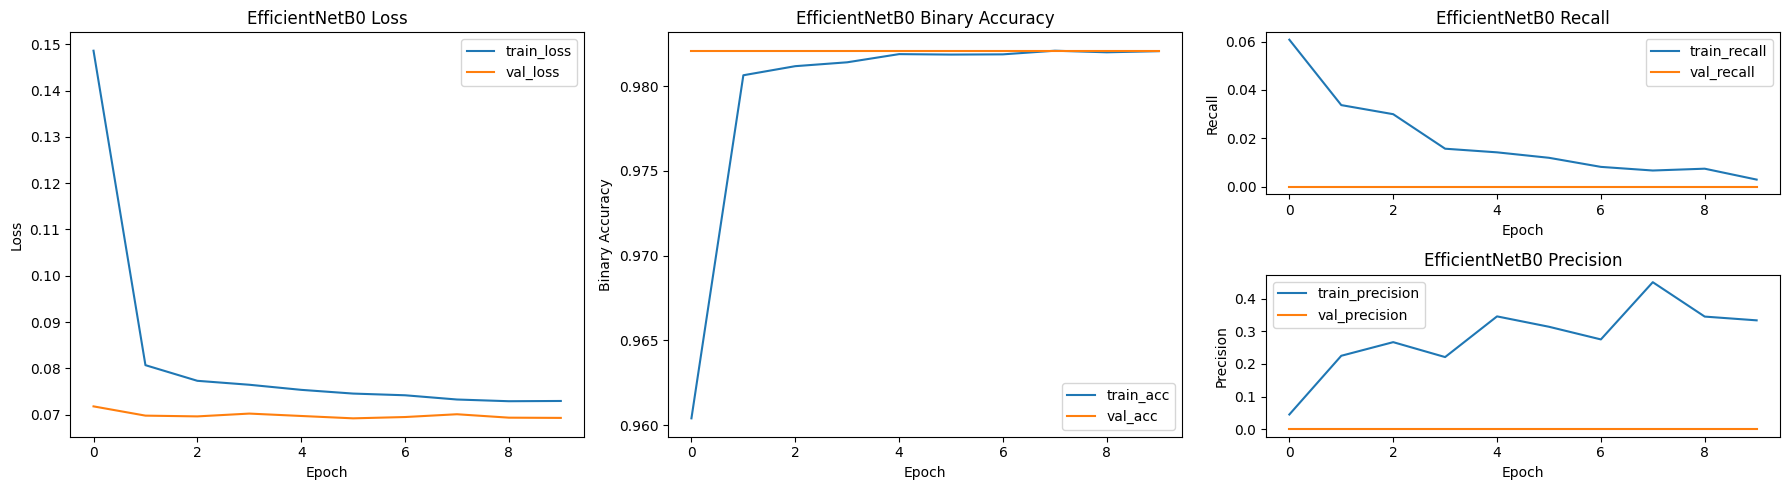

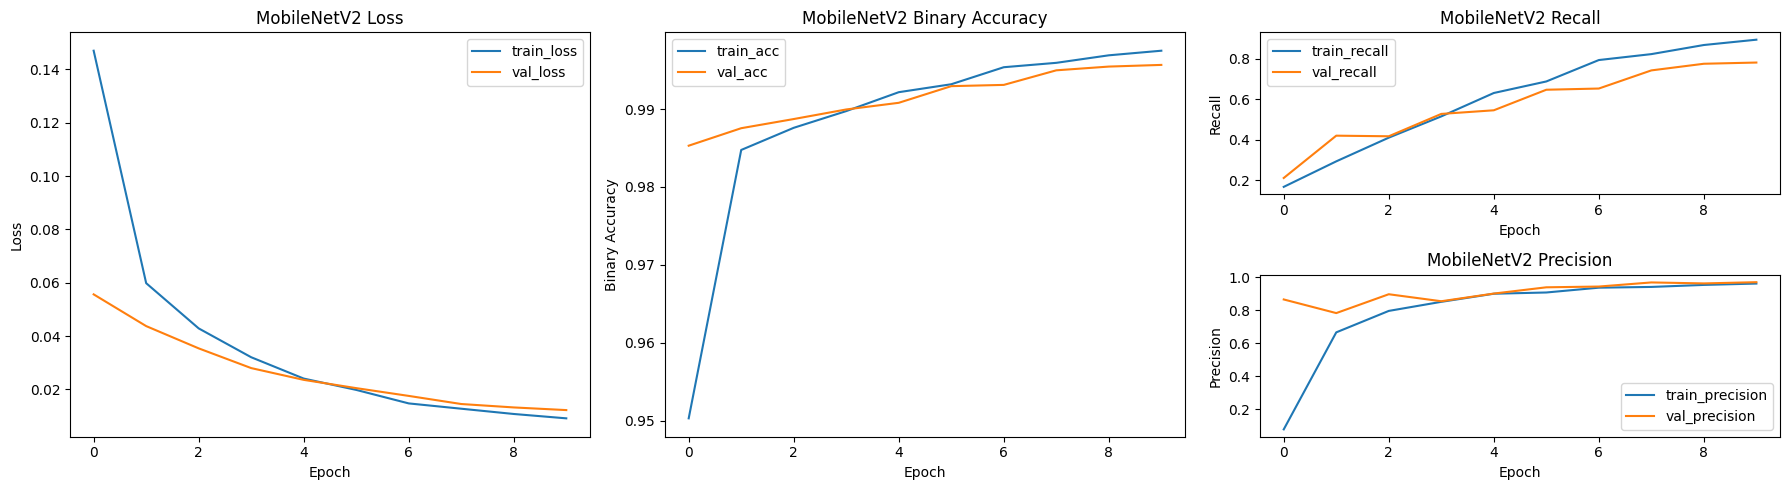

In [21]:
# === 11. Plot training history with separate Precision & Recall ===
import matplotlib.pyplot as plt

def plot_history_separate(history, title="Model Performance"):
    plt.figure(figsize=(18,5))

    # Loss
    plt.subplot(1,3,1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Binary Accuracy
    plt.subplot(1,3,2)
    plt.plot(history.history['binary_accuracy'], label='train_acc')
    plt.plot(history.history['val_binary_accuracy'], label='val_acc')
    plt.title(f'{title} Binary Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Accuracy')
    plt.legend()

    # Precision
    plt.subplot(2,3,6)  # Place precision in lower row
    plt.plot(history.history['precision'], label='train_precision')
    plt.plot(history.history['val_precision'], label='val_precision')
    plt.title(f'{title} Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(2,3,3)  # Place recall in upper row
    plt.plot(history.history['recall'], label='train_recall')
    plt.plot(history.history['val_recall'], label='val_recall')
    plt.title(f'{title} Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for both models
plot_history_separate(history_efficientnet, "EfficientNetB0")
plot_history_separate(history_mobilenet, "MobileNetV2")


In [24]:
# === Visualize sample predictions ===
import pandas as pd
import numpy as np
import tensorflow as tf

def show_sample_predictions(model, val_paths, val_labels, label_cols, sample_size=10):

    idxs = np.random.choice(len(val_paths), size=sample_size, replace=False)
    paths_sample = [val_paths[i] for i in idxs]
    labels_sample = val_labels[idxs]

    # Load and preprocess images
    images = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(p, target_size=(224,224))) / 255.0 for p in paths_sample]
    images = np.array(images)

    # Get predictions
    preds = model.predict(images)
    preds_labels = [[label_cols[j] for j, p in enumerate(pred) if p >= 0.5] for pred in preds]
    actual_labels = [[label_cols[j] for j, l in enumerate(label_row) if l==1] for label_row in labels_sample]

    # Create DataFrame
    df_sample = pd.DataFrame({
        "image_file": paths_sample,
        "predicted_labels": preds_labels,
        "actual_labels": actual_labels
    })
    display(df_sample)

# Example usage:
print("EfficientNetB0 Sample Predictions:")
show_sample_predictions(efficientnet_model, val_paths, val_labels, label_cols, sample_size=20)

print("\nMobileNetV2 Sample Predictions:")
show_sample_predictions(mobilenet_model, val_paths, val_labels, label_cols, sample_size=20)


EfficientNetB0 Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


,image_file,predicted_labels,actual_labels
0,images/img(907).jpg,[],"[Salad, chicken, rice]"
1,images/img(990).jpg,[],[beef]
2,images/img(592).jpg,[],"[meat, rice]"
3,images/img(230).png,[],"[Salad, meat]"
4,images/img(32).jpg,[],[meat]
5,images/img(575).jpg,[],[rice]
6,images/img(913).jpg,[],"[meat, vegetable]"
7,images/img(211).jpg,[],[Pastry]
8,images/img(507).jpg,[],"[chicken, rice]"
9,images/img(294).jpg,[],[kleija]



MobileNetV2 Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


,image_file,predicted_labels,actual_labels
0,images/img(721).jpg,[rice],"[Jareesh, chicken, goursan, rice]"
1,images/img(60).jpg,[Jareesh],[Jareesh]
2,images/img(747).jpg,[meat],[meat]
3,images/img(68).png,[Pastry],[Pastry]
4,images/img(100).png,[rice],[rice]
5,images/img(575).jpg,[rice],[rice]
6,images/img(315).jpg,"[meat, vegetable]","[meat, vegetable]"
7,images/img(1006).jpg,[‘boiled eggs’],"[‘boiled eggs’, ‘bread’]"
8,images/img(973).jpg,[Salad],[Salad]
9,images/img(723).jpg,"[chicken, rice]","[Saleek, chicken]"
